#  Amazon Fine Food Reviews Analysis

### Clustering

Cluster analysis or clustering is the task of grouping a set of objects in such a way that objects in the same group (called a cluster) are more similar (in some sense) to each other than to those in other groups (clusters).

### K-means :

K-means clustering is a type of unsupervised learning, which is used when you have unlabeled data (i.e., data without defined categories or groups). The goal of this algorithm is to find groups in the data, with the number of groups represented by the variable K. The algorithm works iteratively to assign each data point to one of K groups based on the features that are provided. Data points are clustered based on feature similarity. The results of the K-means clustering algorithm are:

1. The centroids of the K clusters, which can be used to label new data
2. Labels for the training data (each data point is assigned to a single cluster)



### Agglomerative clustering

Agglomerative Hierarchical clustering Technique: In this technique, initially each data point is considered as an individual cluster. At each iteration, the similar clusters merge with other clusters until one cluster or K clusters are formed.
The basic algorithm of Agglomerative is straight forward.

1. Compute the proximity matrix
2. Let each data point be a cluster
3. Repeat: Merge the two closest clusters and update the proximity matrix
4. Until only a single cluster remains
5. Key operation is the computation of the proximity of two clusters

## Objective:
#### To Categorize the  Amazon Fine Food Review Using K-means and agglomarative clustering

#### Apply Clustering on
1. Bow(Bag of Words)
2. TF-IDF
3. Average Word2Vec
4. tf-idf Word2Vec


# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

from tqdm import tqdm
import os

C:\Users\User\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
from wordcloud import WordCloud, STOPWORDS
from sklearn.cluster import KMeans, AgglomerativeClustering,DBSCAN
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, make_scorer, silhouette_score

In [3]:
from sklearn import tree
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans

In [4]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [5]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [6]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [7]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [8]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [9]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [10]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [11]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [12]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [13]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [14]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [15]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [16]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [17]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [18]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [19]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [20]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [21]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [22]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [23]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [24]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████| 87773/87773 [00:49<00:00, 1770.31it/s]


In [25]:
preprocessed_reviews[1500]

'way hot blood took bite jig lol'

In [26]:
final['Text'] = preprocessed_reviews
final.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,dogs loves chicken product china wont buying a...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,dogs love saw pet store tag attached regarding...


In [27]:
Data = final.sample(10000)

In [28]:
X = Data['Text']
y = Data['Score']
X.shape

(10000,)

## Hyperparameter

In [29]:
neighbours = [2,3,5,7,8,10]

## Reusable Code

In [30]:
#knn_kd_tree

def bestk(X):
    neighbours = [2,3,5,7,8,10]
    inertia=[]
    for k in neighbours:
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(X)
        inertia.append(kmeans.inertia_)
        
    plt.plot(neighbours,inertia)
    plt.xlabel('Clusters')
    plt.ylabel('intertia')
    plt.show()
    
    best_k = neighbours[inertia.index(min(inertia))] #returns k corresponding to minimum error
    
    return best_k

In [31]:
def agglo(X):
    
    neighbours = [2,3,5,7,8,10]
    scores=[]
    for k in neighbours:
        model = AgglomerativeClustering(n_clusters=k)
        model.fit(X)
        score = silhouette_score(X, model.labels_, random_state=42)
        scores.append(score)

    plt.plot(neighbours, scores)
    plt.xlabel('neighbours')
    plt.ylabel('Silhoutte Score')
    plt.show()
    
    best_k = neighbours[scores.index(min(scores))] #returns k corresponding to minimum error
    
    return best_k

## Splitting into train and test

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test , y_train , y_test = train_test_split(X,y,test_size = 0.33,shuffle='false')
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(6700,) (6700,)
(3300,) (3300,)


##  BAG OF WORDS

In [35]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(X_train)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

X_train_bow = count_vect.transform(X_train)
X_test_bow = count_vect.transform(X_test)
print("the type of count vectorizer ",type(X_train_bow))
print("the shape of out text BOW vectorizer ",X_train_bow.get_shape())
print("the number of unique words ", X_train_bow.get_shape()[1])
print(X_train_bow.shape, y_test.shape)
print(X_test_bow.shape, y_test.shape)

some feature names  ['aa', 'aaa', 'aafco', 'aahs', 'abandon', 'abandoned', 'aberration', 'abetter', 'abid', 'ability']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (6700, 16367)
the number of unique words  16367
(6700, 16367) (3300,)
(3300, 16367) (3300,)


### K-means

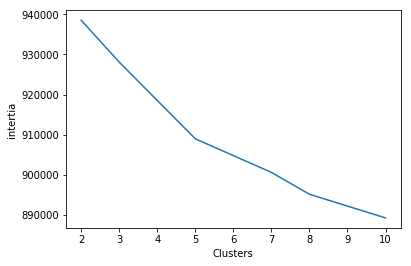

In [35]:
k = bestk(X_train_bow)

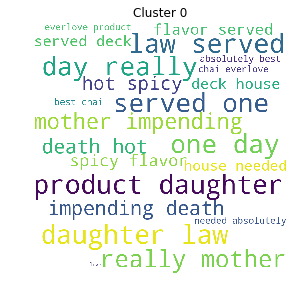

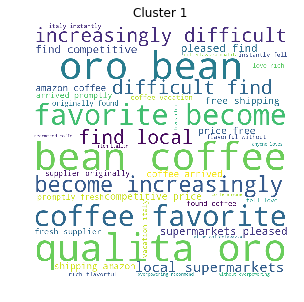

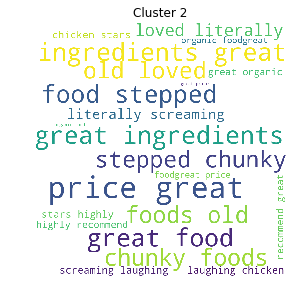

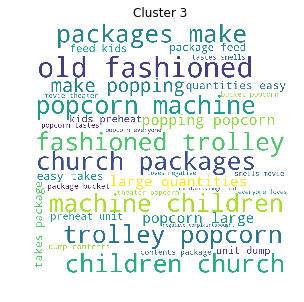

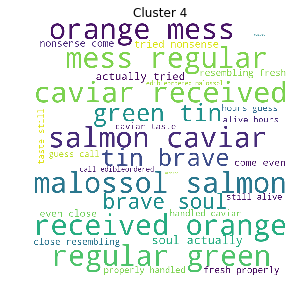

In [38]:

model = KMeans(n_clusters=5, random_state=42, verbose=0)
model.fit(X_train_bow)
cluster_sets = {i: np.where(model.labels_ == i)[0] for i in range(model.n_clusters)}
cluster_reviews = dict()
for i in cluster_sets:
    for j in cluster_sets[i]:
        cluster_reviews[i] = cluster_reviews.get(i, '') + Data.iloc[i]['Text']
        
for i in range(model.n_clusters):
    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white',
                    min_font_size = 10).generate(cluster_reviews[i])

    # plot the WordCloud image
    plt.figure(figsize = (4, 4), facecolor = None)
    plt.imshow(wordcloud) 
    plt.axis("off")
    plt.title(f'Cluster {i}')
    plt.tight_layout(pad = 0)

plt.show()

### Agglomerative Clustering

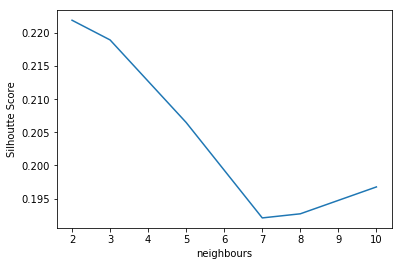

In [64]:
k = agglo(X_train_bow.todense())

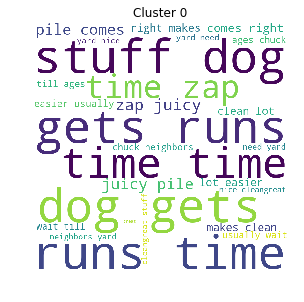

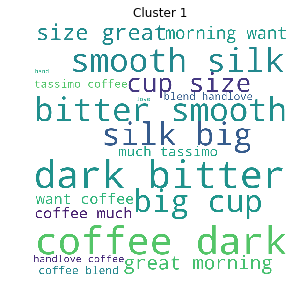

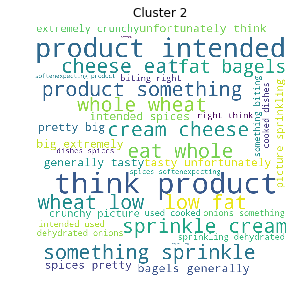

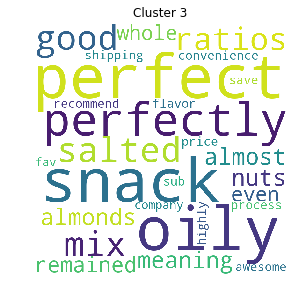

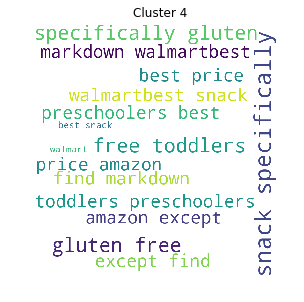

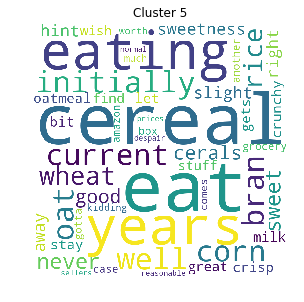

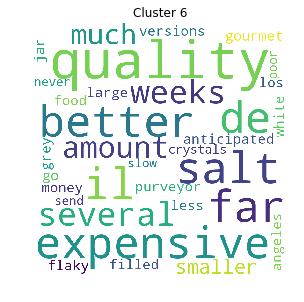

In [68]:
model = AgglomerativeClustering(n_clusters=7)
model.fit(X_train_bow.todense())
cluster_sets = {i: np.where(model.labels_ == i)[0] for i in range(model.n_clusters)}
cluster_reviews = dict()
for i in cluster_sets:
    for j in cluster_sets[i]:
        cluster_reviews[i] = cluster_reviews.get(i, '') + Data.iloc[i]['Text']
        
for i in range(model.n_clusters):
    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white',
                    min_font_size = 10).generate(cluster_reviews[i])

    # plot the WordCloud image
    plt.figure(figsize = (4, 4), facecolor = None)
    plt.imshow(wordcloud) 
    plt.axis("off")
    plt.title(f'Cluster {i}')
    plt.tight_layout(pad = 0)

plt.show()

## TF-IDF

In [34]:
tf_idf_vect = TfidfVectorizer( min_df=10)
tf_idf_vect.fit(X_train)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

X_train_tfidf = tf_idf_vect.transform(X_train)
X_test_tfidf = tf_idf_vect.transform(X_test)

print("\nthe type of count vectorizer ",type(X_train_tfidf))
print("the shape of out text BOW vectorizer ",X_train_tfidf.get_shape())
print("the number of unique words ", X_train_tfidf.get_shape()[1])
print()
print(X_train_tfidf.shape, y_test.shape)
print(X_test_tfidf.shape, y_test.shape)

some sample features(unique words in the corpus) ['ability', 'able', 'absolute', 'absolutely', 'acai', 'accident', 'according', 'account', 'accurate', 'accustomed']

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (6700, 2888)
the number of unique words  2888

(6700, 2888) (3300,)
(3300, 2888) (3300,)


## K-means

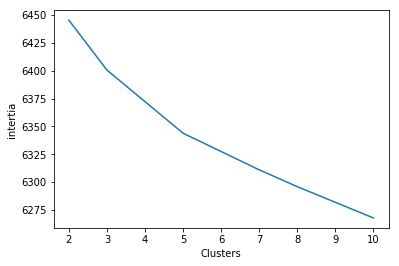

In [35]:
k = bestk(X_train_tfidf)

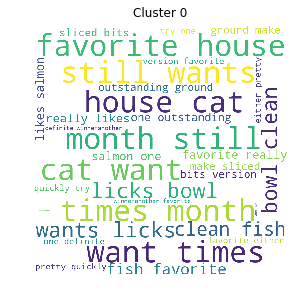

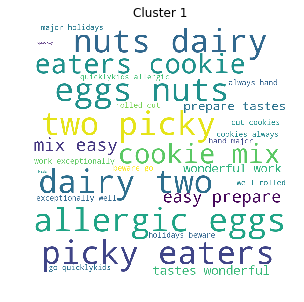

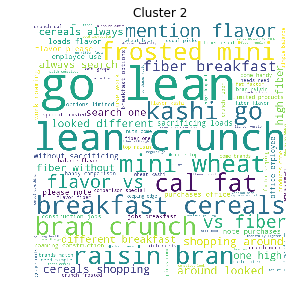

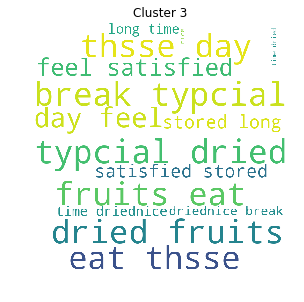

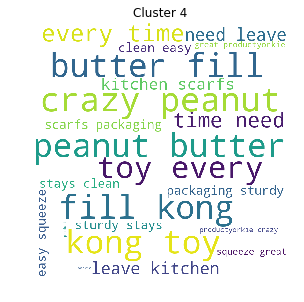

In [36]:
model = KMeans(n_clusters=5, random_state=42, verbose=0)
model.fit(X_train_tfidf)
cluster_sets = {i: np.where(model.labels_ == i)[0] for i in range(model.n_clusters)}
cluster_reviews = dict()
for i in cluster_sets:
    for j in cluster_sets[i]:
        cluster_reviews[i] = cluster_reviews.get(i, '') + Data.iloc[i]['Text']
        
for i in range(model.n_clusters):
    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white',
                    min_font_size = 10).generate(cluster_reviews[i])

    # plot the WordCloud image
    plt.figure(figsize = (4, 4), facecolor = None)
    plt.imshow(wordcloud) 
    plt.axis("off")
    plt.title(f'Cluster {i}')
    plt.tight_layout(pad = 0)

plt.show()

### Agglomerative Clustering

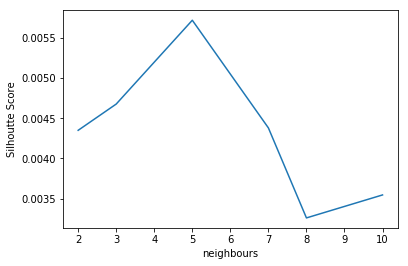

In [37]:
k = agglo(X_train_tfidf.todense())

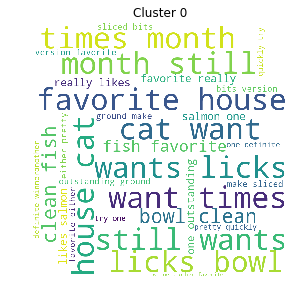

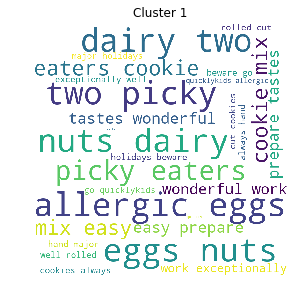

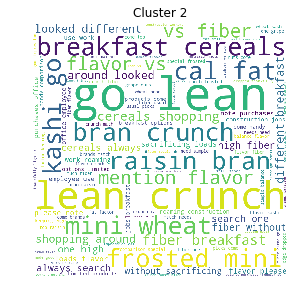

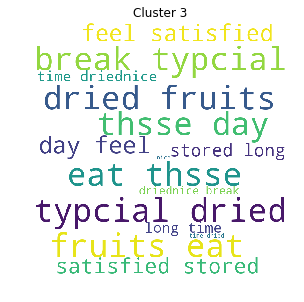

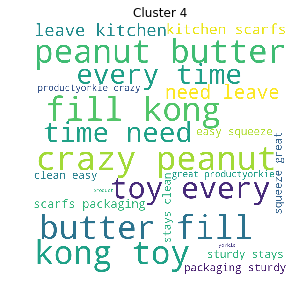

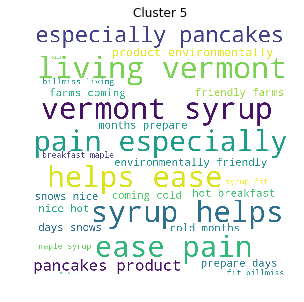

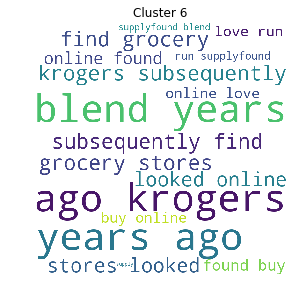

In [38]:
model = AgglomerativeClustering(n_clusters=7)
model.fit(X_train_tfidf.todense())
cluster_sets = {i: np.where(model.labels_ == i)[0] for i in range(model.n_clusters)}
cluster_reviews = dict()
for i in cluster_sets:
    for j in cluster_sets[i]:
        cluster_reviews[i] = cluster_reviews.get(i, '') + Data.iloc[i]['Text']
        
for i in range(model.n_clusters):
    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white',
                    min_font_size = 10).generate(cluster_reviews[i])

    # plot the WordCloud image
    plt.figure(figsize = (4, 4), facecolor = None)
    plt.imshow(wordcloud) 
    plt.axis("off")
    plt.title(f'Cluster {i}')
    plt.tight_layout(pad = 0)

plt.show()

## Word2Vec

In [34]:
i=0
list_of_train_sentance=[]
for sentance in X_train:
    list_of_train_sentance.append(sentance.split())

list_of_test_sentance=[]
for sentance in X_test:
    list_of_test_sentance.append(sentance.split())

In [35]:
w2v_model=Word2Vec(list_of_train_sentance,min_count=5,size=50, workers=4)

In [36]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  4872
sample words  ['birthday', 'gift', 'friend', 'confirmed', 'delicious', 'kept', 'plaque', 'last', 'read', 'previous', 'reviews', 'prepared', 'taste', 'coconut', 'water', 'chose', 'vita', 'w', 'acai', 'pomegranate', 'hydrating', 'weight', 'loss', 'heart', 'healthy', 'beneficial', 'actually', 'liked', 'fresh', 'found', 'choosing', 'whenever', 'desired', 'something', 'drink', 'also', 'pleased', 'container', 'prefer', 'plastic', 'bottles', 'definately', 'noticed', 'change', 'appetite', 'days', 'strongly', 'considering', 'delivery', 'not']


##  Converting text into vectors using Avg W2V, TFIDF-W2V

## Avg W2v

In [37]:
# average Word2Vec
# compute average word2vec for each review.
#sent_vectors = [];
train_vectors= [];
# the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_train_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_vectors.append(sent_vec)
print(len(train_vectors))
print(len(train_vectors[0]))

100%|█████████████████████████████████████| 6700/6700 [00:13<00:00, 514.91it/s]


6700
50


In [38]:
# average Word2Vec
# compute average word2vec for each review.
#sent_vectors = [];
test_vectors= [];
# the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_test_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_vectors.append(sent_vec)
print(len(test_vectors))
print(len(test_vectors[0]))

100%|█████████████████████████████████████| 3300/3300 [00:05<00:00, 620.14it/s]


3300
50


In [39]:
X_test_w2v =np.nan_to_num(test_vectors) 
X_train_w2v =np.nan_to_num(train_vectors)
print(X_train_w2v.shape , y_train.shape)
print(X_test_w2v.shape,y_test.shape)

(6700, 50) (6700,)
(3300, 50) (3300,)


### K-Means

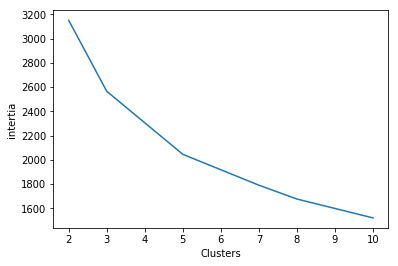

In [40]:
k = bestk(X_train_w2v)

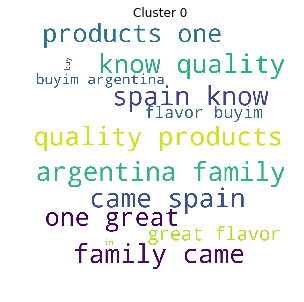

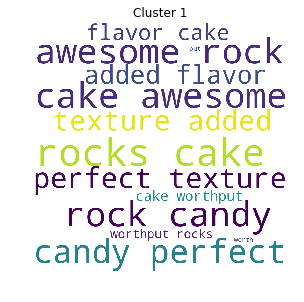

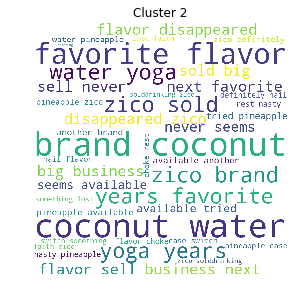

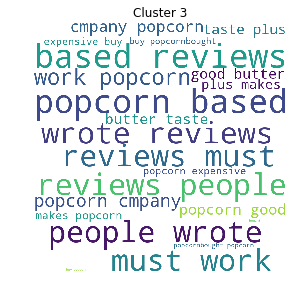

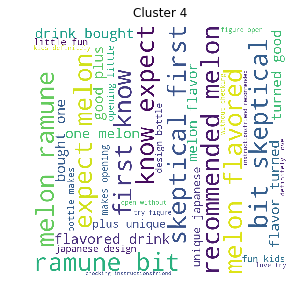

In [41]:
model = KMeans(n_clusters=5, random_state=42, verbose=0)
model.fit(X_train_w2v)
cluster_sets = {i: np.where(model.labels_ == i)[0] for i in range(model.n_clusters)}
cluster_reviews = dict()
for i in cluster_sets:
    for j in cluster_sets[i]:
        cluster_reviews[i] = cluster_reviews.get(i, '') + Data.iloc[i]['Text']
        
for i in range(model.n_clusters):
    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white',
                    min_font_size = 10).generate(cluster_reviews[i])

    # plot the WordCloud image
    plt.figure(figsize = (4, 4), facecolor = None)
    plt.imshow(wordcloud) 
    plt.axis("off")
    plt.title(f'Cluster {i}')
    plt.tight_layout(pad = 0)

plt.show()

## Agglomarative Clustering

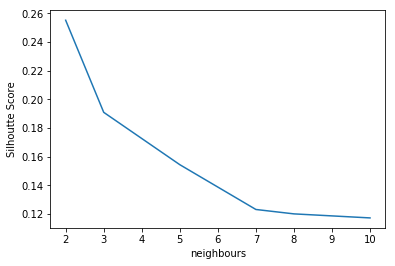

In [42]:
k = agglo(X_train_w2v)

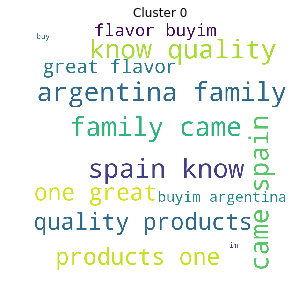

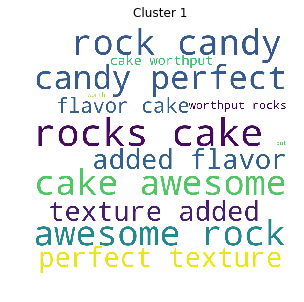

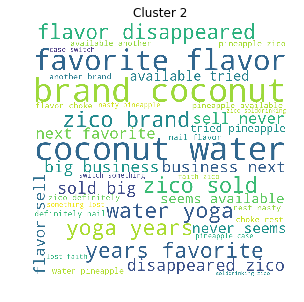

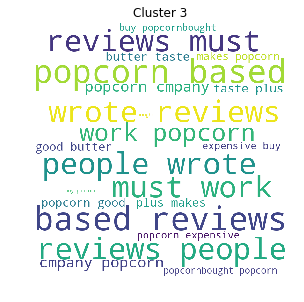

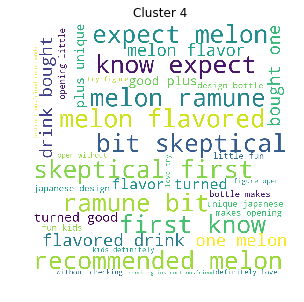

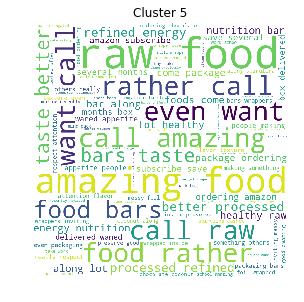

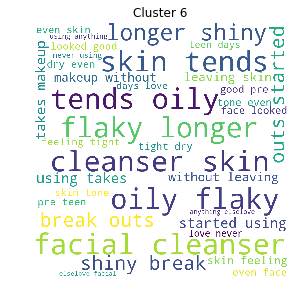

In [43]:
model = AgglomerativeClustering(n_clusters=7)
model.fit(X_train_w2v)
cluster_sets = {i: np.where(model.labels_ == i)[0] for i in range(model.n_clusters)}
cluster_reviews = dict()
for i in cluster_sets:
    for j in cluster_sets[i]:
        cluster_reviews[i] = cluster_reviews.get(i, '') + Data.iloc[i]['Text']
        
for i in range(model.n_clusters):
    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white',
                    min_font_size = 10).generate(cluster_reviews[i])

    # plot the WordCloud image
    plt.figure(figsize = (4, 4), facecolor = None)
    plt.imshow(wordcloud) 
    plt.axis("off")
    plt.title(f'Cluster {i}')
    plt.tight_layout(pad = 0)

plt.show()

### DBSCAN

In [47]:
model = DBSCAN(eps = 0.3 )
model.fit(X_train_w2v)
labels = model.labels_
cluster_set = len(set(labels)) - (1 if -1 in labels else 0)

cluster_sets = list(cluster_set)
for i in cluster_sets:
    for j in cluster_sets[i]:
        cluster_reviews[i] = cluster_reviews.get(i, '') + Data.iloc[i]['Text']
        
for i in range(model.labels_):
    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white',
                    min_font_size = 10).generate(cluster_reviews[i])

    # plot the WordCloud image
    plt.figure(figsize = (4, 4), facecolor = None)
    plt.imshow(wordcloud) 
    plt.axis("off")
    plt.title(f'Cluster {i}')
    plt.tight_layout(pad = 0)

plt.show()

TypeError: 'int' object is not iterable

## TF-IDF Word2Vec

In [44]:
i=0
list_of_train_sentance=[]
for sentance in X_train:
    list_of_train_sentance.append(sentance.split())

list_of_test_sentance=[]
for sentance in X_test:
    list_of_test_sentance.append(sentance.split())
    
w2v_model=Word2Vec(list_of_train_sentance,min_count=5,size=50, workers=4)

w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  4936
sample words  ['tried', 'brand', 'flavors', 'one', 'personal', 'opinion', 'far', 'best', 'perfect', 'taste', 'mango', 'never', 'heard', 'quite', 'personally', 'addicting', 'right', 'amount', 'sweetness', 'pulp', 'drink', 'also', 'soft', 'goes', 'smooth', 'could', 'literally', 'open', 'cap', 'whole', 'bottle', 'good', 'not', 'sure', 'cost', 'since', 'item', 'currently', 'stock', 'hawaii', 'live', 'usually', 'find', 'would', 'pay', 'unless', 'no', 'stars', 'pamela', 'brownie']


In [45]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [46]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_train_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|██████████████████████████████████████| 6700/6700 [01:25<00:00, 78.03it/s]


In [47]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_test_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|██████████████████████████████████████| 3300/3300 [00:40<00:00, 81.73it/s]


In [48]:
X_test_w2v =np.nan_to_num(tfidf_sent_vectors_test) 
X_train_w2v =np.nan_to_num(tfidf_sent_vectors_train)

print(X_train_w2v.shape , y_train.shape)
print(X_test_w2v.shape,y_test.shape)

(6700, 50) (6700,)
(3300, 50) (3300,)


## K-means

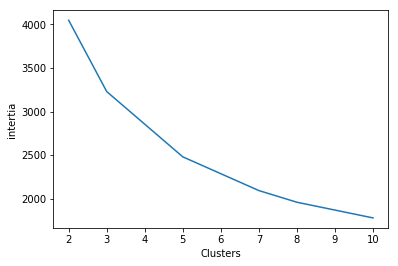

In [49]:
k = bestk(X_train_w2v)

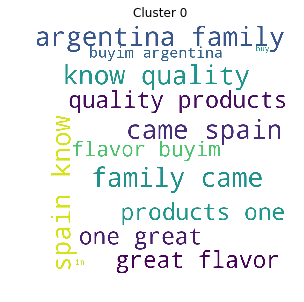

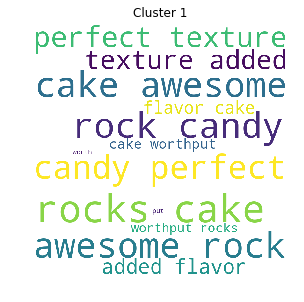

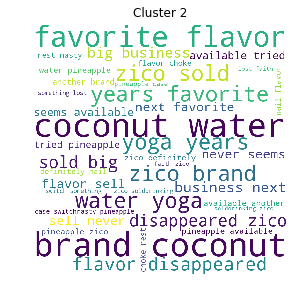

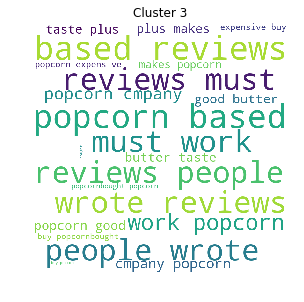

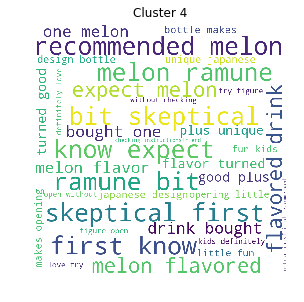

In [50]:
model = KMeans(n_clusters=5, random_state=42, verbose=0)
model.fit(X_train_w2v)
cluster_sets = {i: np.where(model.labels_ == i)[0] for i in range(model.n_clusters)}
cluster_reviews = dict()
for i in cluster_sets:
    for j in cluster_sets[i]:
        cluster_reviews[i] = cluster_reviews.get(i, '') + Data.iloc[i]['Text']
        
for i in range(model.n_clusters):
    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white',
                    min_font_size = 10).generate(cluster_reviews[i])

    # plot the WordCloud image
    plt.figure(figsize = (4, 4), facecolor = None)
    plt.imshow(wordcloud) 
    plt.axis("off")
    plt.title(f'Cluster {i}')
    plt.tight_layout(pad = 0)

plt.show()

## Agglomarative clustering

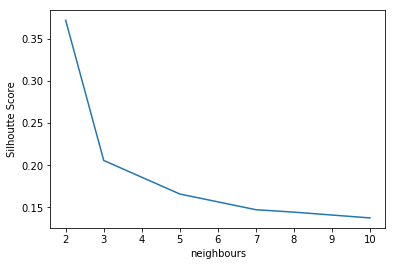

In [51]:
k = agglo(X_train_w2v)

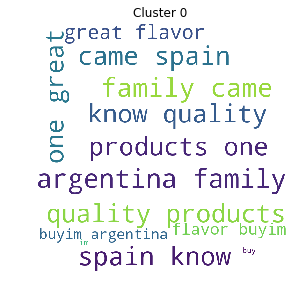

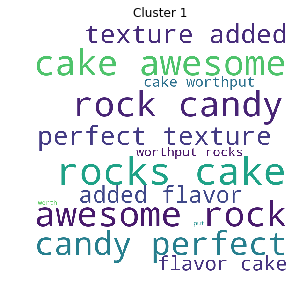

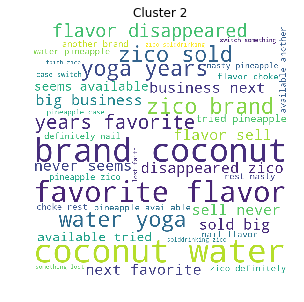

In [52]:
model = AgglomerativeClustering(n_clusters=3)
model.fit(X_train_w2v)
cluster_sets = {i: np.where(model.labels_ == i)[0] for i in range(model.n_clusters)}
cluster_reviews = dict()
for i in cluster_sets:
    for j in cluster_sets[i]:
        cluster_reviews[i] = cluster_reviews.get(i, '') + Data.iloc[i]['Text']
        
for i in range(model.n_clusters):
    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white',
                    min_font_size = 10).generate(cluster_reviews[i])

    # plot the WordCloud image
    plt.figure(figsize = (4, 4), facecolor = None)
    plt.imshow(wordcloud) 
    plt.axis("off")
    plt.title(f'Cluster {i}')
    plt.tight_layout(pad = 0)

plt.show()

## Thank you